In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm
import csv

## Поиск минимума сетке

In [2]:
m1 = 2e30
m2 = 5.7e26
r2 = 60270
r12 = 1429*1e6
v2 = 9.7
m3 = 2.3e21
r3 = 764
r23 = 527e3
v3 = 7.54

In [3]:
with open('data.csv', 'r', newline = '') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        csv_data = np.array(row, dtype = np.float64)

In [4]:
x1 = 0
y1 = 0
x2 = r12
y2 = 0
x3 = r12+r23
y3 = 0

vx1 = 0
vy1 = 0
vx2 = 0
vy2 = v2
vx3 = 0
vy3 = v2 + v3

In [5]:
'''
x1 = csv_data[0]
y1 = csv_data[1]
x2 = csv_data[2]
y2 = csv_data[3]
x3 = csv_data[4]
y3 = csv_data[5]

vx1 = csv_data[6]
vy1 = csv_data[7]
vx2 = csv_data[8]
vy2 = csv_data[9]
vx3 = csv_data[10]
vy3 = csv_data[11]
'''

'\nx1 = csv_data[0]\ny1 = csv_data[1]\nx2 = csv_data[2]\ny2 = csv_data[3]\nx3 = csv_data[4]\ny3 = csv_data[5]\n\nvx1 = csv_data[6]\nvy1 = csv_data[7]\nvx2 = csv_data[8]\nvy2 = csv_data[9]\nvx3 = csv_data[10]\nvy3 = csv_data[11]\n'

In [6]:
g = 6.67430e-11 / 1e9

In [7]:
def f_gr(p1, p2):
    return g*(p2 - p1)/(np.linalg.norm(p1 - p2))**3

In [8]:
def rot_angle(a, b):
    _a = a / np.linalg.norm(a)
    _b = b / np.linalg.norm(b)
    ang = np.arccos((_a @ _b))
    _c = _b @ np.array([[np.cos(ang), np.sin(ang)], [-np.sin(ang), np.cos(ang)]])
    _d = _b @ np.array([[np.cos(-ang), np.sin(-ang)], [-np.sin(-ang), np.cos(-ang)]])
    if (_c @ _a) < (_d @ _a):
        return -ang
    else:
        return ang

In [9]:
all_data = None
fuel_off_idx = None
orb_idx = -1
coll_idx = -1
orb = False     # достиг орбиты
coll = False    # попал

In [10]:
m_pg = 100.  # масса полезного груза
t_fuel = 3400.
h = 350.
u = 3.031   # скорость выброса топлива
alpha = 0.025   # доля конструкции

In [11]:
#t_end = 60*60*24*4.5*10
t_end = t_fuel * 1000
n = 1_000
dt = t_end / n

In [12]:
m_fuel_min = 1700.
m_fuel_max = 1790.

In [13]:
plot_traj = True
plot_every_traj = False

In [14]:
sector_num = 25
dm = 0.5

In [15]:
center = 259.2

In [16]:
start_ang = center - 2
end_ang = center + 1

In [17]:
ang_arr = np.linspace(2*np.pi/360 * start_ang, 2*np.pi/360 * end_ang, sector_num+1)[:-1]
m_fuel_arr = np.array([-1.]*sector_num)

In [18]:
has_coll_arr = [False]*sector_num

In [19]:
optim_fuel = m_fuel_max

In [20]:
cosmic_speed = 0.6 + np.sqrt(g*m2/(r2+h)) # первая космическая

  0%|          | 0/25 [00:00<?, ?it/s]

(811, 16)


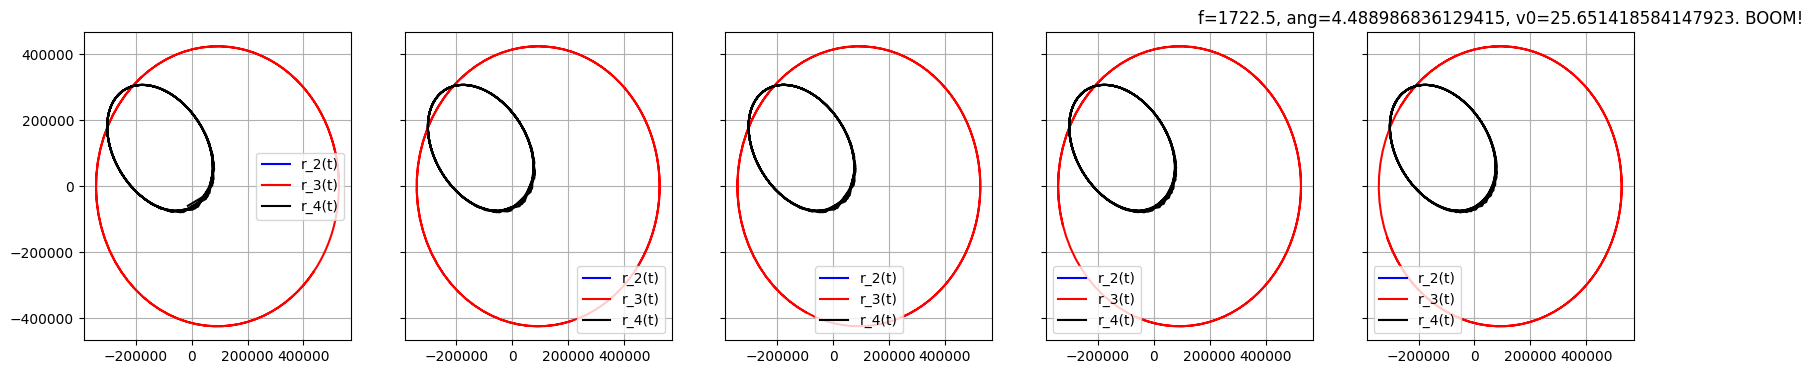

  4%|▍         | 1/25 [00:20<08:21, 20.88s/it]

(811, 16)


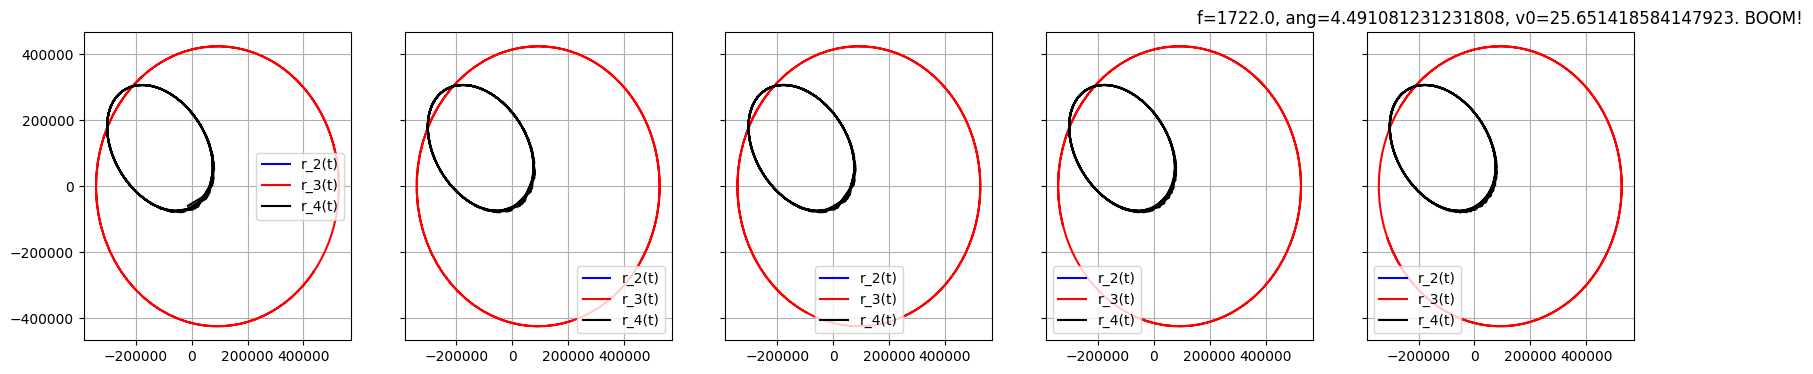

  8%|▊         | 2/25 [00:41<07:52, 20.54s/it]

(811, 16)


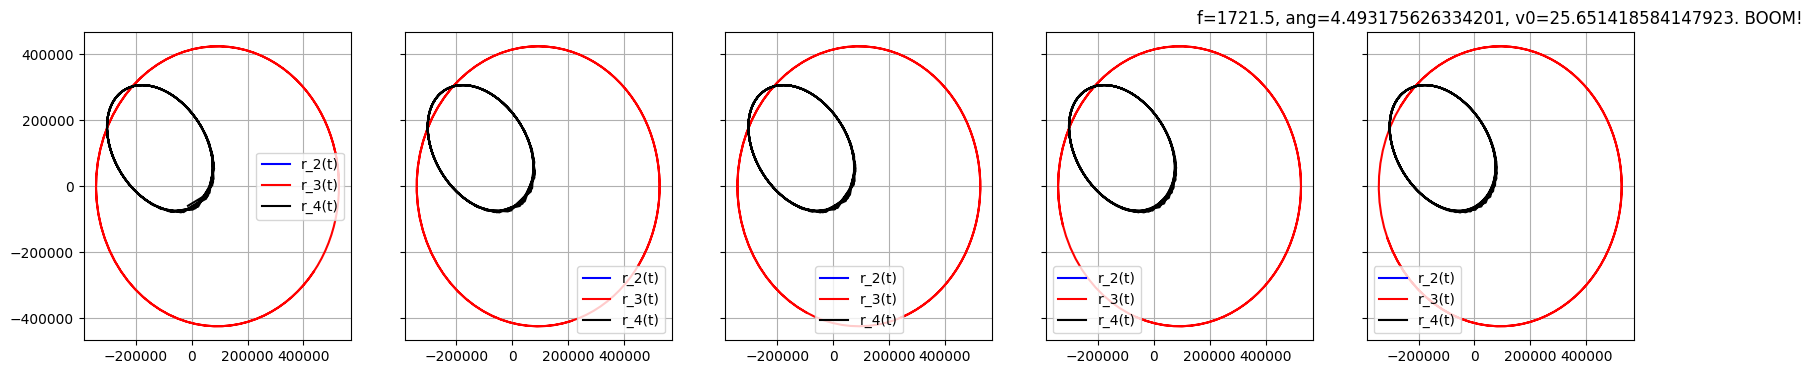

 12%|█▏        | 3/25 [01:01<07:26, 20.28s/it]

(811, 16)


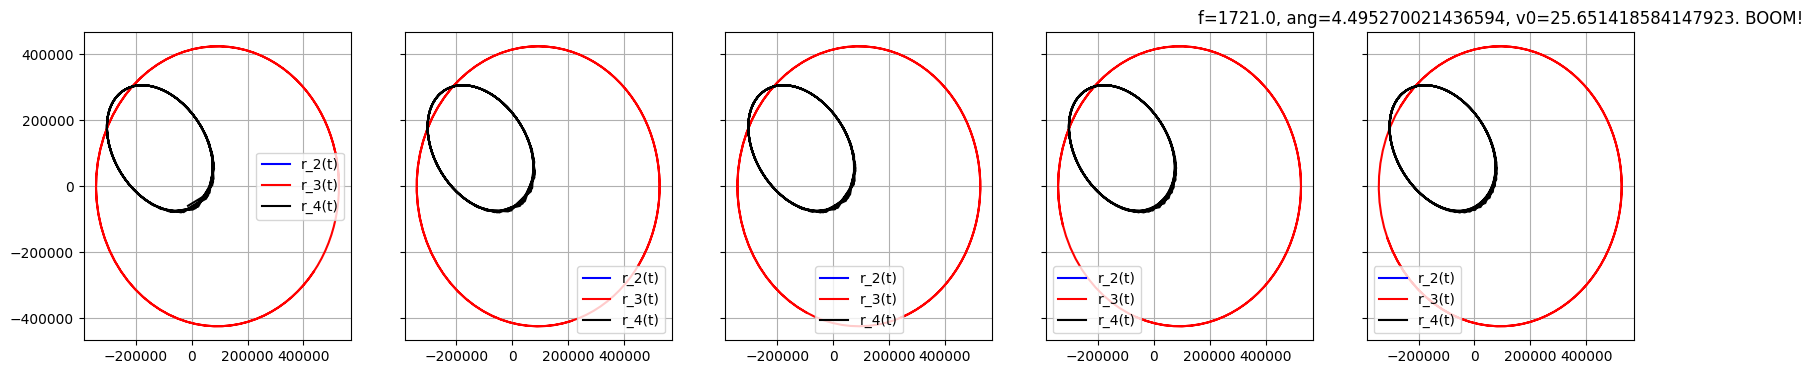

 16%|█▌        | 4/25 [01:20<06:56, 19.83s/it]

(210, 16)


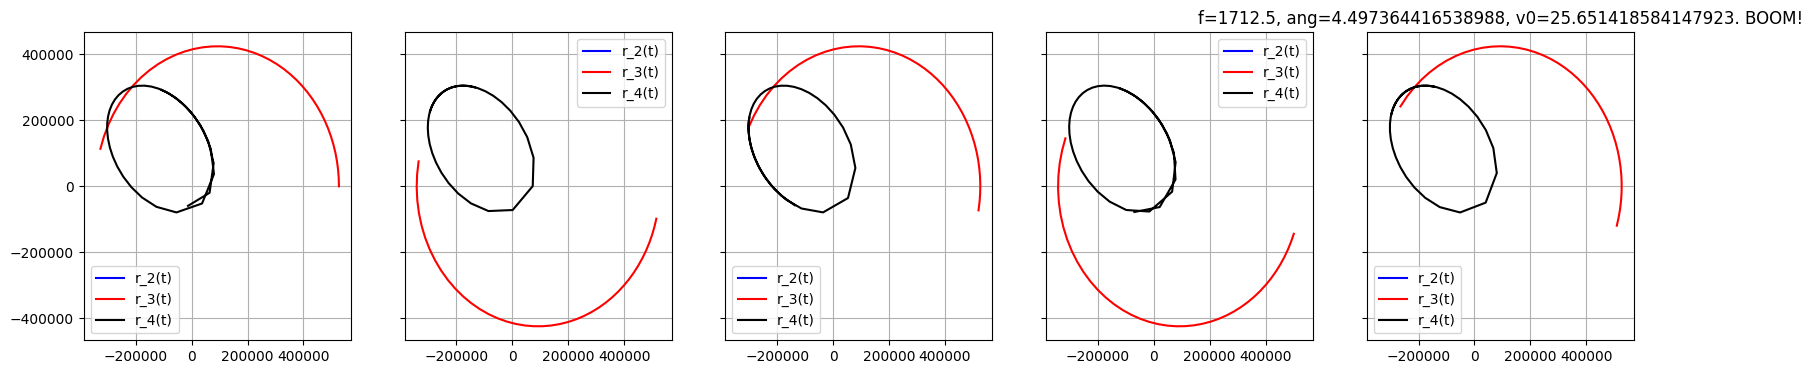

 20%|██        | 5/25 [01:32<05:40, 17.01s/it]

(210, 16)


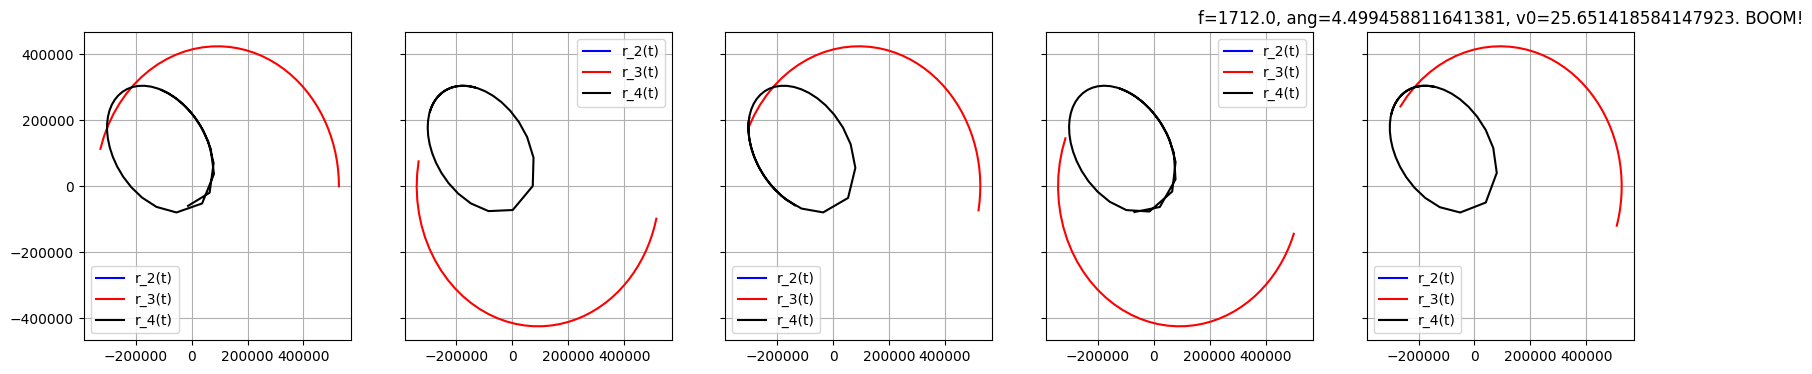

 24%|██▍       | 6/25 [01:44<04:49, 15.22s/it]

(210, 16)


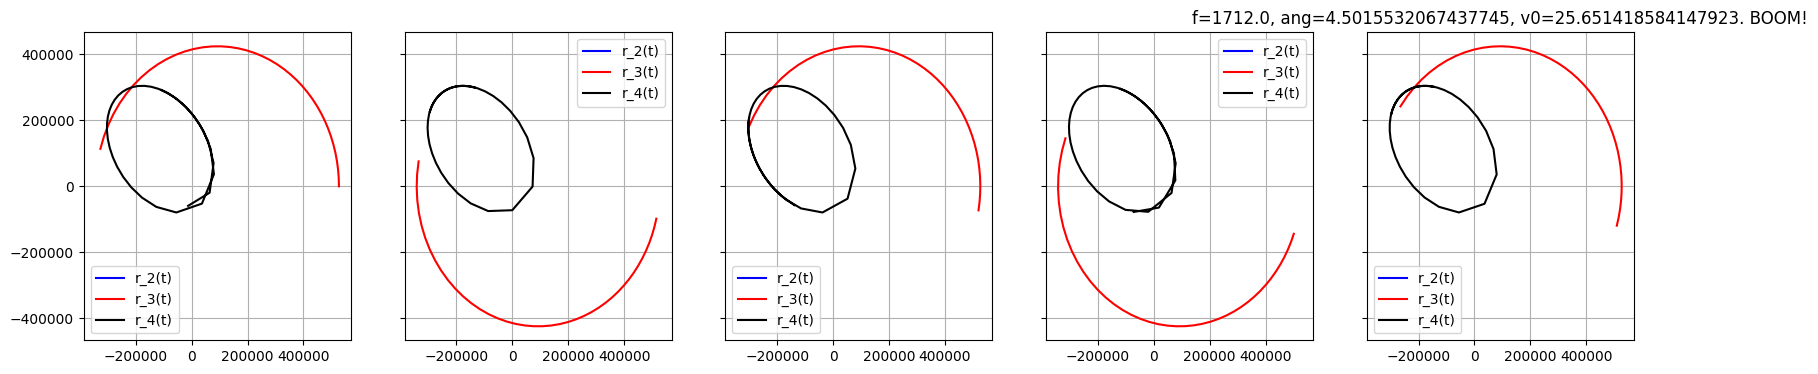

 28%|██▊       | 7/25 [01:55<04:11, 13.95s/it]

(210, 16)


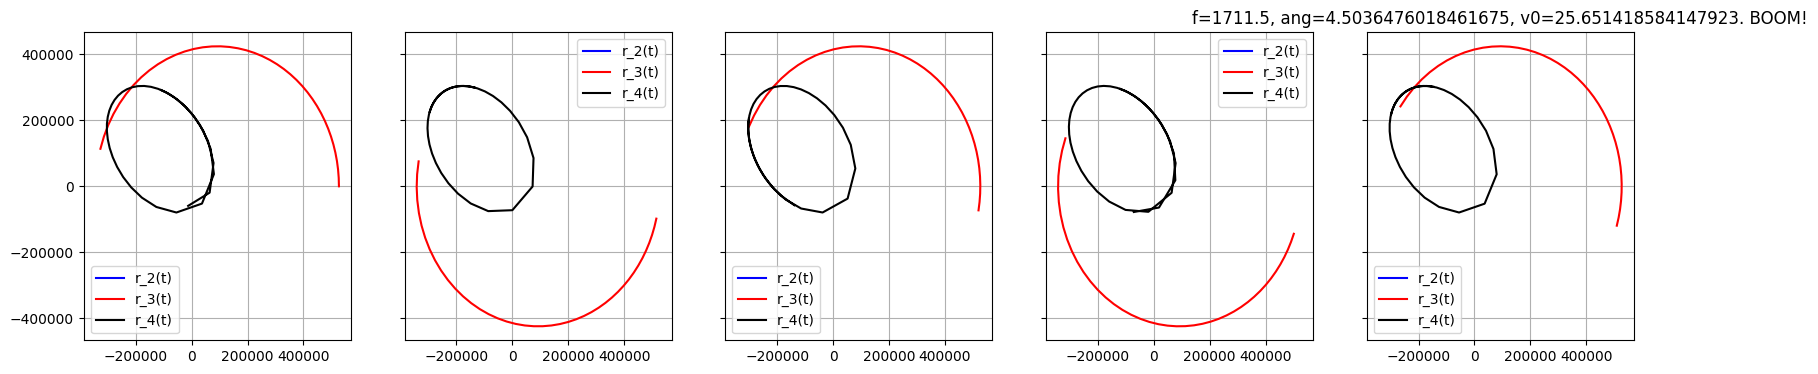

 32%|███▏      | 8/25 [02:06<03:40, 12.99s/it]

(983, 16)


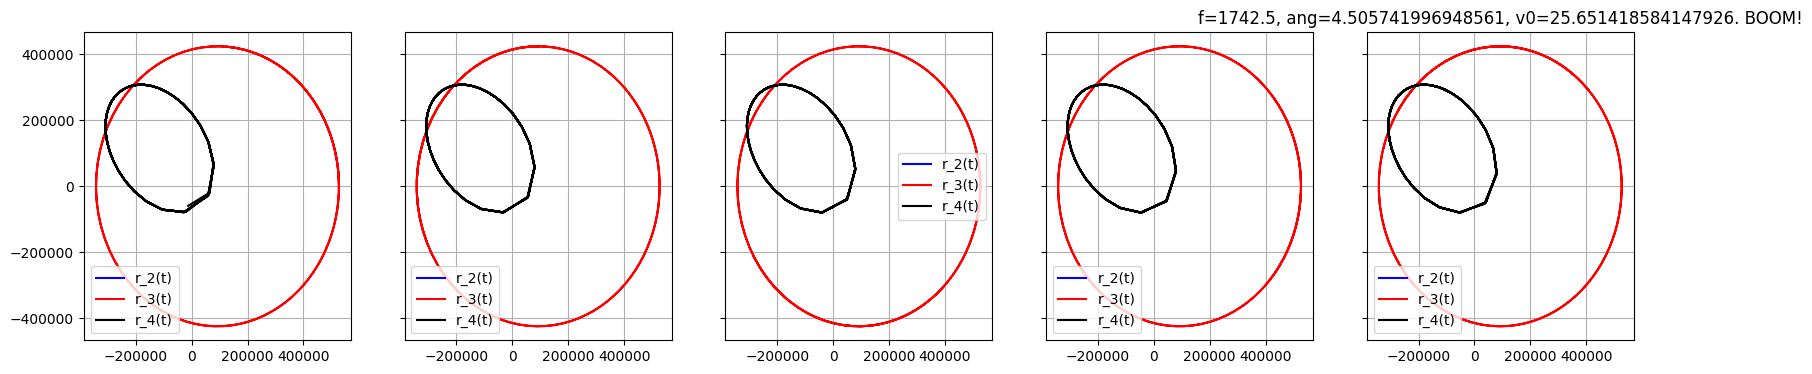

 60%|██████    | 15/25 [10:50<12:15, 73.55s/it]

(897, 16)


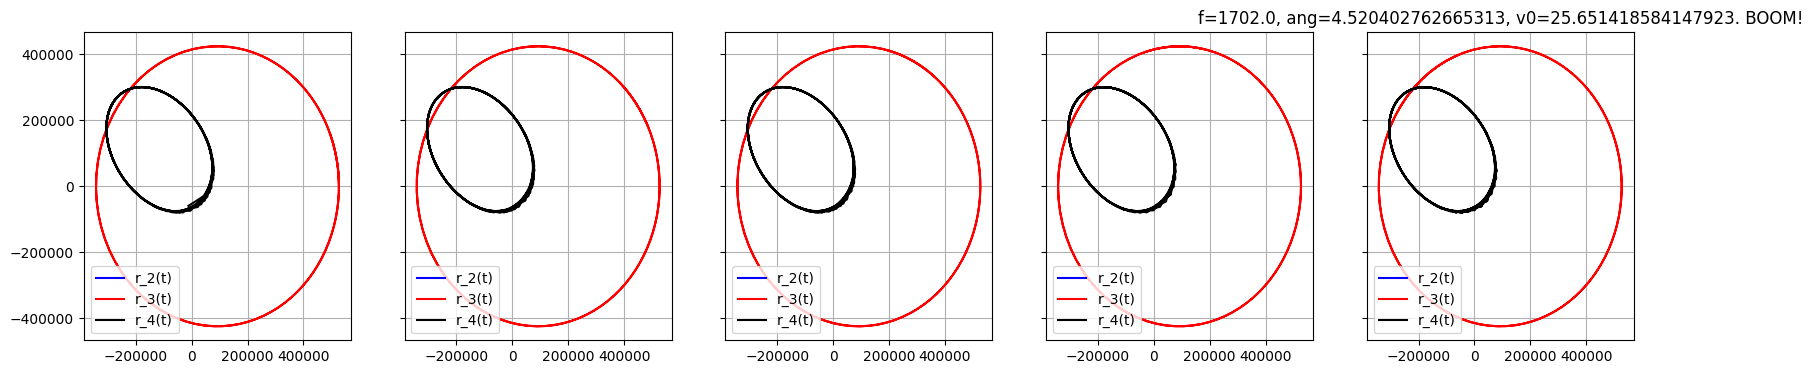

 64%|██████▍   | 16/25 [10:53<07:49, 52.20s/it]

(897, 16)


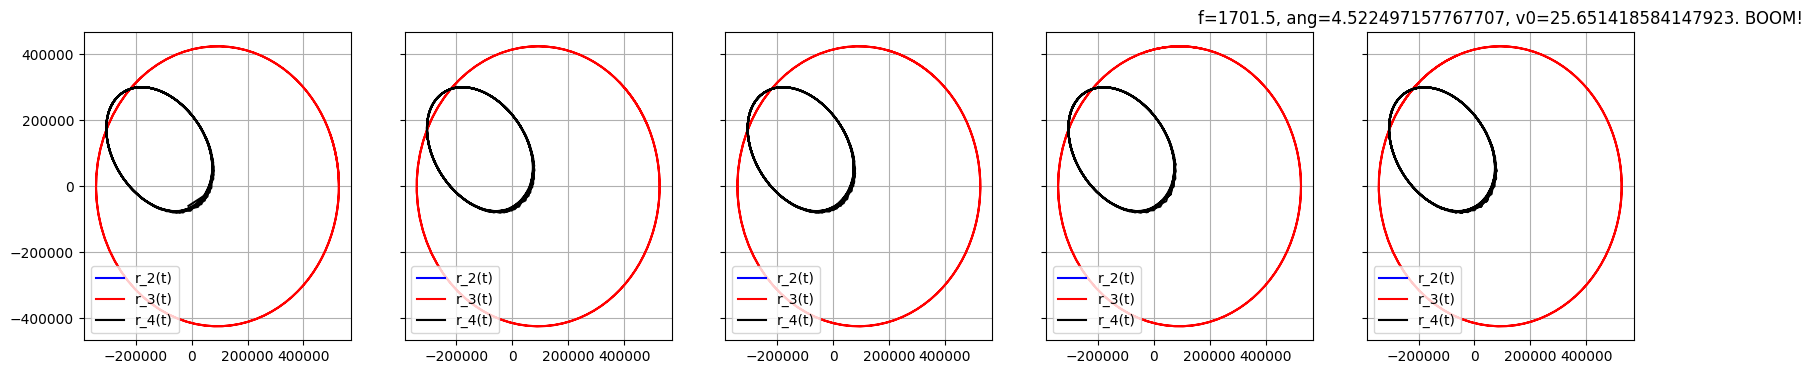

 68%|██████▊   | 17/25 [10:55<04:57, 37.14s/it]

(897, 16)


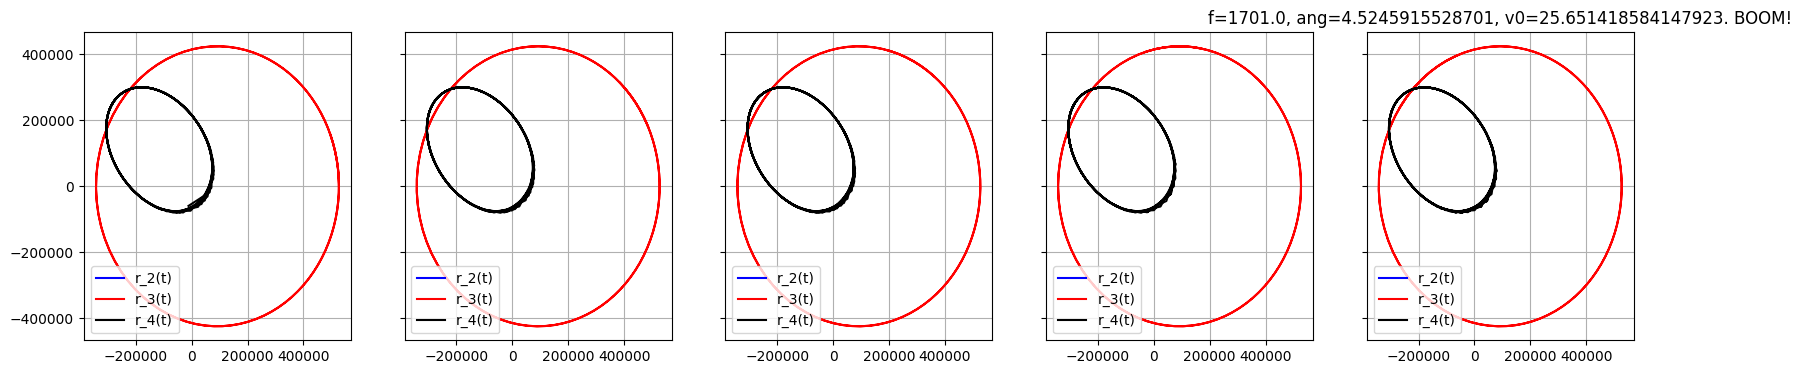

 72%|███████▏  | 18/25 [10:57<03:05, 26.49s/it]

(897, 16)


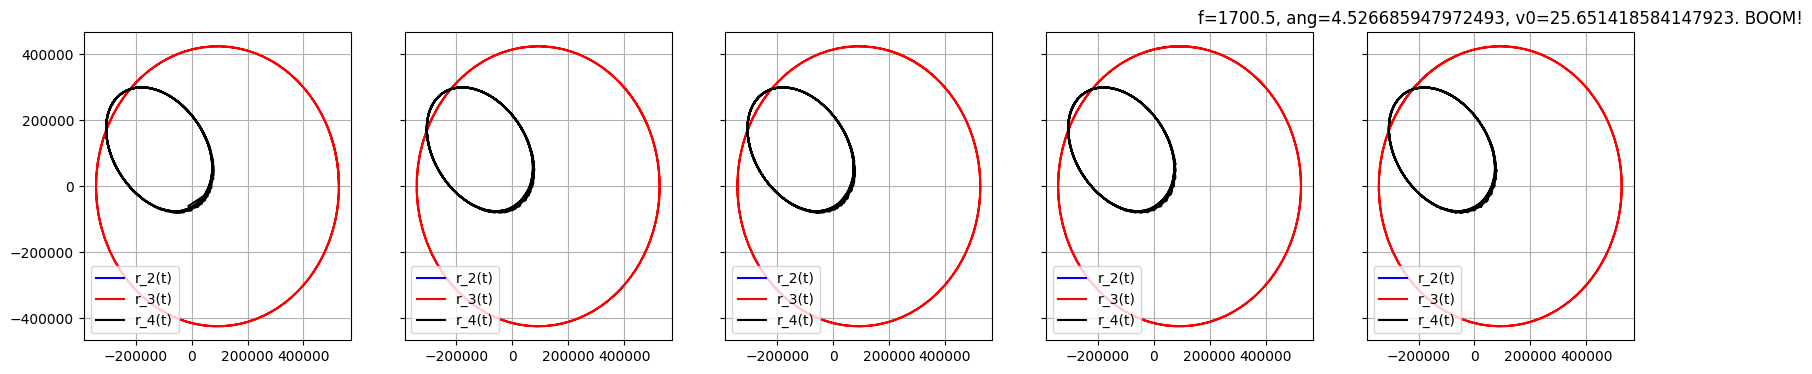

 80%|████████  | 20/25 [12:17<03:04, 36.82s/it]

(468, 16)


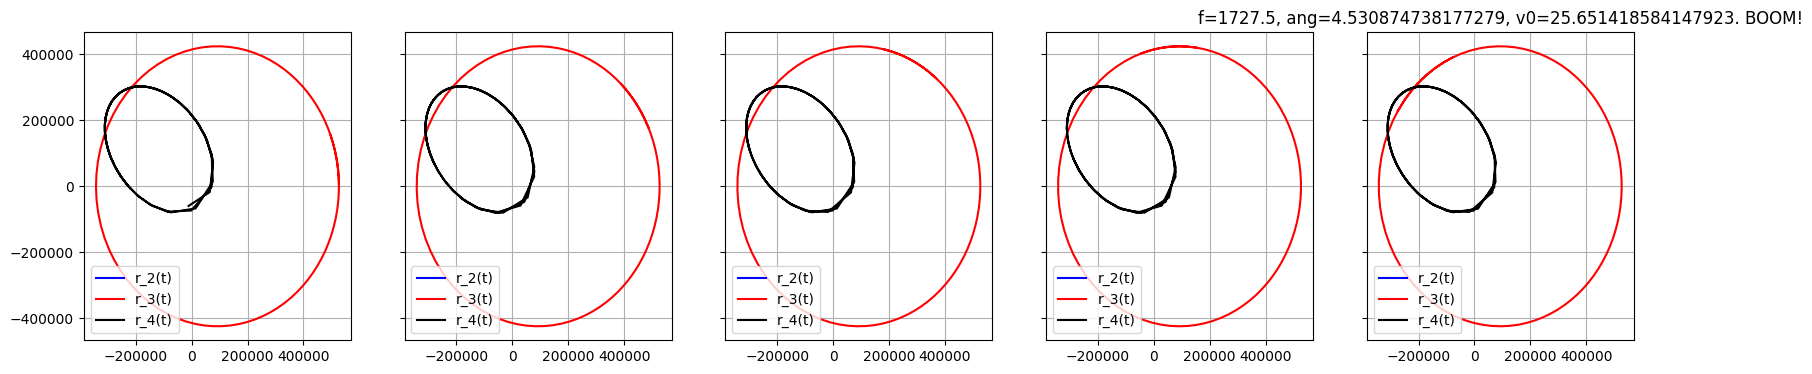

 84%|████████▍ | 21/25 [12:42<02:13, 33.30s/it]

(468, 16)


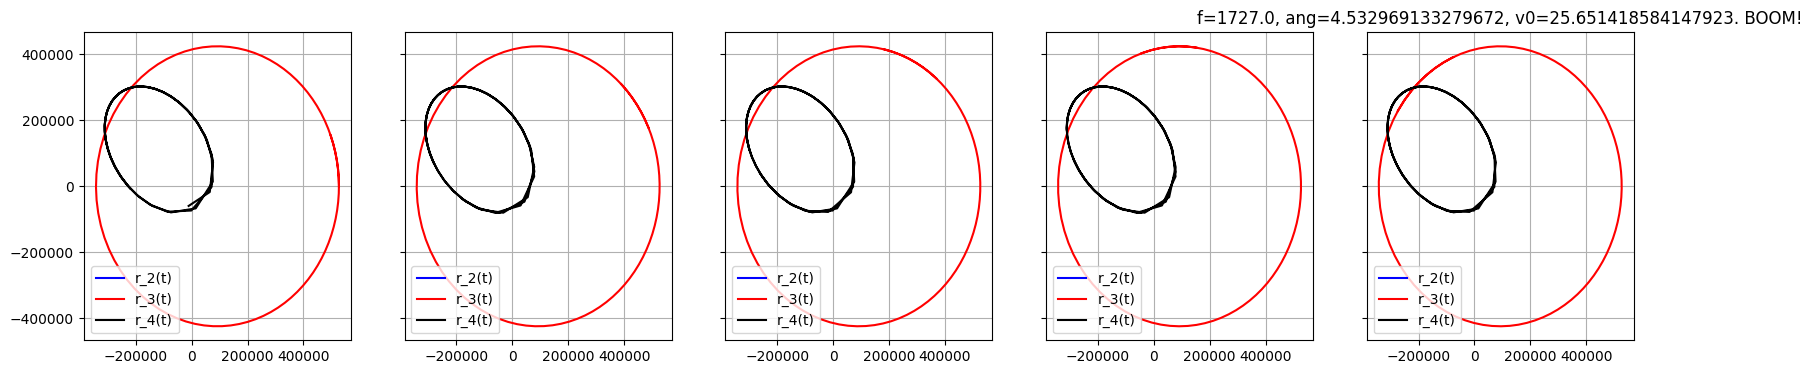

 96%|█████████▌| 24/25 [15:40<00:54, 54.05s/it]

(640, 16)


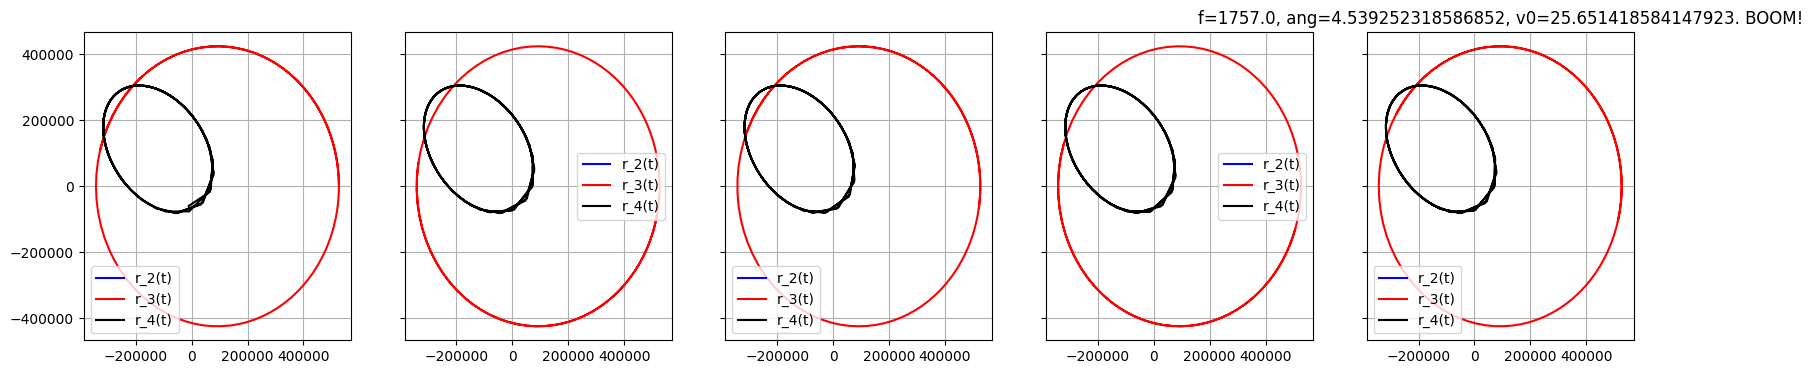

100%|██████████| 25/25 [16:29<00:00, 39.58s/it]


In [342]:
for i in tqdm(range(sector_num)):
    cur_ang = ang_arr[i]
    cur_m_fuel_0 = m_fuel_min

    while cur_m_fuel_0 <= m_fuel_max:
        #print(cur_m_fuel_0)

        m_cons = alpha * (cur_m_fuel_0 + m_pg) / (1 - alpha)

        def m_fuel(t):
            return 0 if t > t_fuel else cur_m_fuel_0 * (t_fuel - t)/t_fuel

        def m_r(t):
            return m_fuel(t) + m_cons + m_pg

        def f_react(t, v):
            return np.zeros(2) if t > t_fuel else v * u * cur_m_fuel_0 / (t_fuel*np.linalg.norm(v)*m_r(t))

        def system_full(y, t):
            dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7 = y[8:]
            f_12 = f_gr(y[0:2], y[2:4])
            f_13 = f_gr(y[0:2], y[4:6])
            f_1r = f_gr(y[0:2], y[6:8])
            f_23 = f_gr(y[2:4], y[4:6])
            f_2r = f_gr(y[2:4], y[6:8])
            f_3r = f_gr(y[4:6], y[6:8])
            dydt8, dydt9 = m2*f_12 + m3*f_13 + m_r(t)*f_1r
            dydt10, dydt11 = -m1*f_12 + m3*f_23 + m_r(t)*f_2r
            dydt12, dydt13 = -m1*f_13 - m2*f_23 + m_r(t)*f_3r
            dydt14, dydt15 =  -m1*f_1r - m2*f_2r -m3*f_3r + f_react(t, y[14:16])
            return np.array([dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7, dydt8, dydt9, dydt10, dydt11, dydt12, dydt13, dydt14, dydt15])

        #sputnik x, y
        r_r_init = np.array([x2, y2 ]) + np.array([r2+h, 0]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
        #sputnik vel
        v_r_init = np.array([vx2, vy2]) + np.array([0, cosmic_speed]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
        
        init_cond = np.array([x1,y1, x2, y2, x3, y3, r_r_init[0], r_r_init[1], vx1, vy1, vx2, vy2, vx3, vy3, v_r_init[0], v_r_init[1]])

        # init_cond = np.array([0,0, r12, 0, r12+r23, 0, r12+r2+h, 0, 0, 0, 0, v2, 0, v2+v3, 0, v2+np.sqrt(g*m2/(r2+h))])
        assert len(init_cond) == 16

        y_cur = init_cond.copy()
        t_cur = 0.
        # all_data = np.zeros((n, 16))

        # orb_idx = -1
        coll_idx = -1
        # orb = False
        coll = False

        t_eval = np.linspace(0, t_end, n+1)
        sol = odeint(system_full, init_cond, t_eval)

        for j in range(n):
            if np.linalg.norm(sol[j,4:6] - sol[j,6:8]) <= r3:
                coll_idx = j
                coll = True
                break
            # dist = np.linalg.norm(sol[j,2:4] - sol[j,6:8])
            # if max_r_2r < dist:
            #     max_r_2r = dist
            # elif (dist < max_r_2r) and (max_r_2r < (r23 - r3)):
            #     break

        if plot_every_traj:
            # Plot the solution
            frames = 2
            fig, ax = plt.subplots(1, frames, figsize = (4*frames, 4), sharex=True, sharey=True)
            all_data = sol
            if coll:
                all_data = all_data[:coll_idx]
            idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
            print(all_data.shape)
            for fr, idx in enumerate(idxs[1:]):
                draw_data = all_data[idxs[fr]:idx]
                ax[fr].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='r_2(t)')
                ax[fr].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='r_3(t)')
                ax[fr].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='r_4(t)')
                # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
                ax[fr].legend()
                ax[fr].grid(True)
            plt.title('f={}, ang={}, v0={}.{}'.format(cur_m_fuel_0, cur_ang, np.linalg.norm(v_r_init - np.array([0, v2])), ' BOOM!' if coll else ""))
            plt.show()

        has_coll_arr[i] = coll
        
        if coll:
            if plot_traj:
                # Plot the solution
                frames = 5
                fig, ax = plt.subplots(1, frames, figsize = (4*frames, 4), sharex=True, sharey=True)
                all_data = sol
                if coll:
                    all_data = all_data[:coll_idx]
                idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
                print(all_data.shape)
                for fr, idx in enumerate(idxs[1:]):
                    draw_data = all_data[idxs[fr]:idx]
                    ax[fr].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='r_2(t)')
                    ax[fr].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='r_3(t)')
                    ax[fr].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='r_4(t)')
                    # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
                    ax[fr].legend()
                    ax[fr].grid(True)
                plt.title('f={}, ang={}, v0={}.{}'.format(cur_m_fuel_0, cur_ang, np.linalg.norm(v_r_init - np.array([0, v2])), ' BOOM!' if coll else ""))
                plt.show()
            m_fuel_arr[i] = cur_m_fuel_0
            if optim_fuel > cur_m_fuel_0:
                optim_fuel = cur_m_fuel_0
            break

        cur_m_fuel_0 += dm

In [343]:
ang_arr[has_coll_arr]

array([4.48898684, 4.49108123, 4.49317563, 4.49527002, 4.49736442,
       4.49945881, 4.50155321, 4.5036476 , 4.505742  , 4.52040276,
       4.52249716, 4.52459155, 4.52668595, 4.53087474, 4.53296913,
       4.53925232])

In [344]:
m_fuel_arr[has_coll_arr]

array([1722.5, 1722. , 1721.5, 1721. , 1712.5, 1712. , 1712. , 1711.5,
       1742.5, 1702. , 1701.5, 1701. , 1700.5, 1727.5, 1727. , 1757. ])

In [212]:
np.save('ang_arr.npy', ang_arr)
np.save('m_fuel_arr.npy', m_fuel_arr)

In [345]:
ang_arr_coll = ang_arr[m_fuel_arr > 0]
m_fuel_arr_coll = m_fuel_arr[m_fuel_arr > 0]

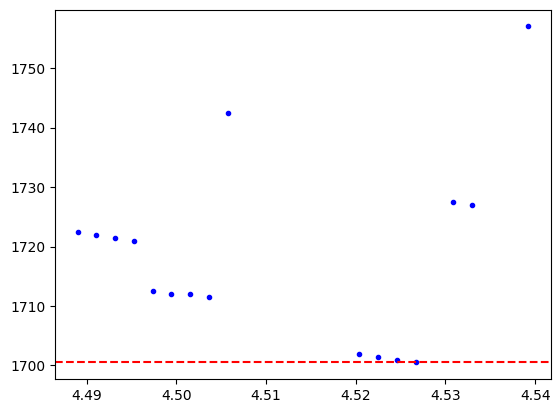

In [346]:
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b.')
plt.axhline(y=optim_fuel, color='r', linestyle='--')
plt.show()

In [215]:
np.save('ang_arr_coll.npy', ang_arr_coll)
np.save('m_fuel_arr_coll.npy', m_fuel_arr_coll)

In [347]:
ang_arr_coll = np.load('ang_arr_coll.npy')
m_fuel_arr_coll = np.load('m_fuel_arr_coll.npy')
optim_fuel = min(m_fuel_arr_coll)

In [348]:
opt_idx = m_fuel_arr_coll.argmin()

In [349]:
optim_fuel = m_fuel_arr_coll[opt_idx]
optim_ang = ang_arr_coll[opt_idx]

## Расчёт траектории по найденным оптимальным параметрам

In [21]:
optim_fuel = 1700.5
optim_ang = 4.52668595

In [31]:
m_cons = alpha * (optim_fuel + m_pg) / (1 - alpha)

def m_fuel(t):
    return 0 if t > t_fuel else optim_fuel * (t_fuel - t)/t_fuel

def m_r(t):
    return m_fuel(t) + m_cons + m_pg

def f_react(t, v):
    return np.zeros(2) if t > t_fuel else v * u * optim_fuel / (t_fuel*np.linalg.norm(v)*m_r(t))

def system_full(y, t):
    dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7 = y[8:]
    f_12 = f_gr(y[0:2], y[2:4])
    f_13 = f_gr(y[0:2], y[4:6])
    f_1r = f_gr(y[0:2], y[6:8])
    f_23 = f_gr(y[2:4], y[4:6])
    f_2r = f_gr(y[2:4], y[6:8])
    f_3r = f_gr(y[4:6], y[6:8])
    dydt8, dydt9 = m2*f_12 + m3*f_13 + m_r(t)*f_1r
    dydt10, dydt11 = -m1*f_12 + m3*f_23 + m_r(t)*f_2r
    dydt12, dydt13 = -m1*f_13 - m2*f_23 + m_r(t)*f_3r
    dydt14, dydt15 =  -m1*f_1r - m2*f_2r -m3*f_3r + f_react(t, y[14:16])
    return np.array([dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7, dydt8, dydt9, dydt10, dydt11, dydt12, dydt13, dydt14, dydt15])


r_r_init = np.array([x2, y2 ]) + np.array([r2+h, 0]) @ np.array([[np.cos(optim_ang), np.sin(optim_ang)], [-np.sin(optim_ang), np.cos(optim_ang)]])
v_r_init = np.array([0, v2]) + np.array([0, cosmic_speed]) @ np.array([[np.cos(optim_ang), np.sin(optim_ang)], [-np.sin(optim_ang), np.cos(optim_ang)]])
init_cond = np.array([0,0, r12, 0, r12+r23, 0, r_r_init[0], r_r_init[1], 0, 0, 0, v2, 0, v2+v3, v_r_init[0], v_r_init[1]])



# init_cond = np.array([0,0, r12, 0, r12+r23, 0, r12+r2+h, 0, 0, 0, 0, v2, 0, v2+v3, 0, v2+np.sqrt(g*m2/(r2+h))])
assert len(init_cond) == 16

y_cur = init_cond.copy()
t_cur = 0.
# all_data = np.zeros((n, 16))

# orb_idx = -1
coll_idx = -1
# orb = False
coll = False

t_eval = np.linspace(0, t_end, n+1)
sol = odeint(system_full, init_cond, t_eval)

for j in range(n):
    if np.linalg.norm(sol[j,4:6] - sol[j,6:8]) <= r3:
        print('sputnik:', sol[j,4:6])
        print('rocket:', sol[j,6:8])
        print('distance: ', np.linalg.norm(sol[j,4:6] - sol[j,6:8]))
        coll_idx = j
        coll = True
        break

sputnik: [1.42839048e+09 2.97520385e+07]
rocket: [1.42838981e+09 2.97517355e+07]
distance:  729.5554356371525


(1000, 16)


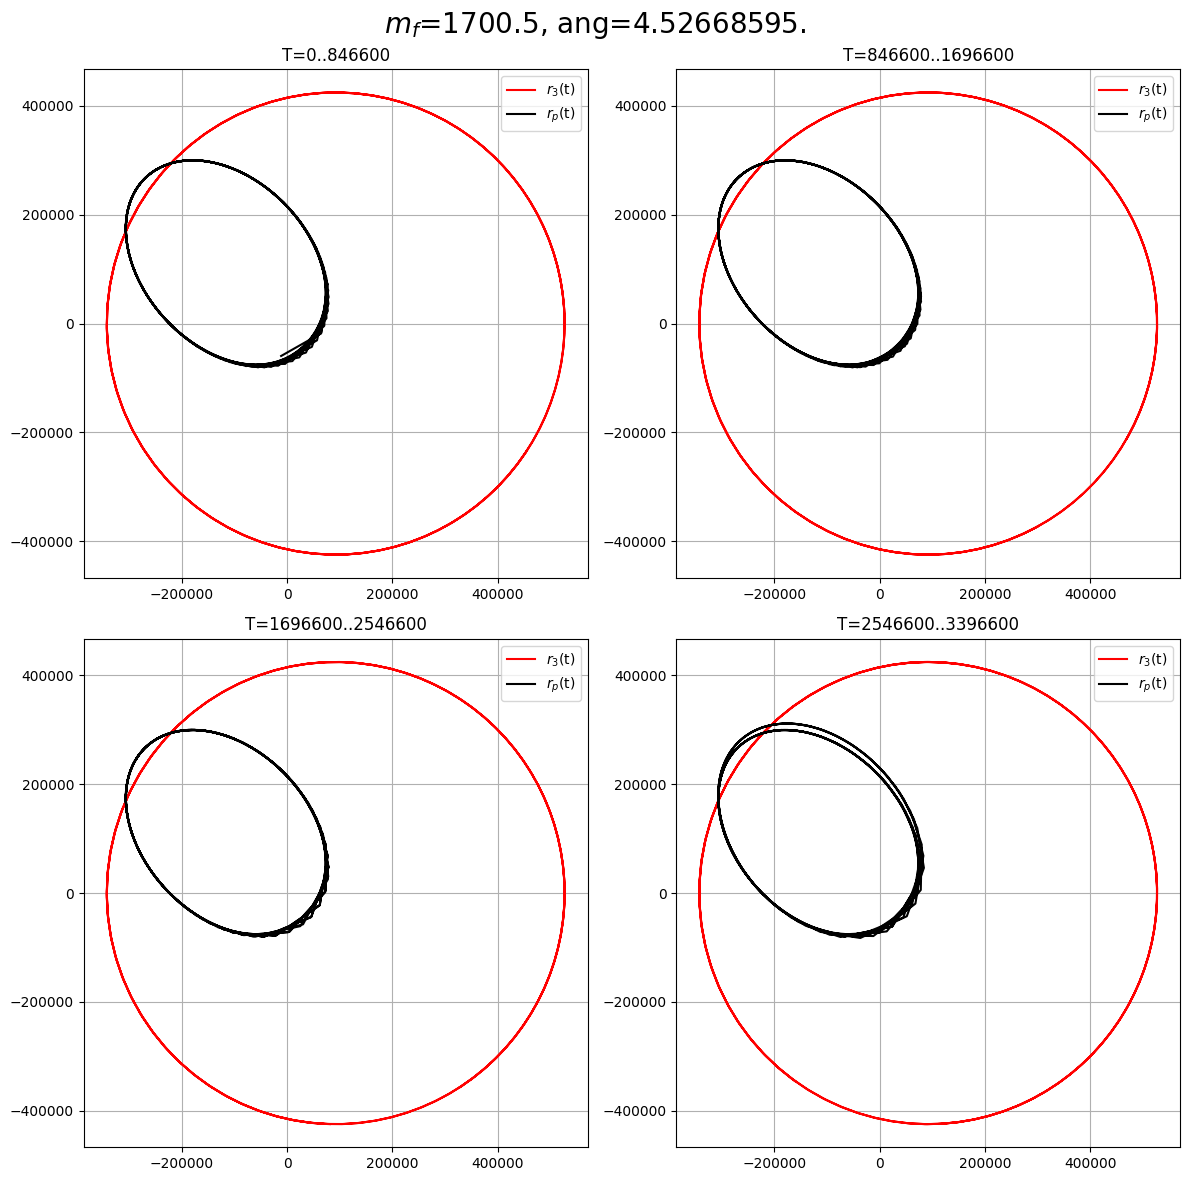

In [28]:
frames = 4
fig, ax = plt.subplots(2, 2, figsize = (6*2, 6*2), sharex=True, sharey=True)
all_data = sol[:coll_idx]
idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
print(all_data.shape)
for fr, idx in enumerate(idxs[1:]):
    draw_data = all_data[idxs[fr]:idx]
    # ax[fr//2,fr%2].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='$r_2$(t)')
    ax[fr//2,fr%2].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='$r_3$(t)')
    ax[fr//2,fr%2].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='$r_р$(t)')
    # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
    ax[fr//2,fr%2].legend()
    ax[fr//2,fr%2].grid(True)
    ax[fr//2,fr%2].set_title('T={:.0f}..{:.0f}'.format(t_eval[idxs[fr]],t_eval[idx]))
    ax[fr//2,fr%2].xaxis.set_tick_params(labelbottom=True)
    ax[fr//2,fr%2].yaxis.set_tick_params(labelbottom=True)
fig.suptitle(f'$m_f$={optim_fuel}, ang={optim_ang}.', fontsize=20)
fig.tight_layout()
plt.show()

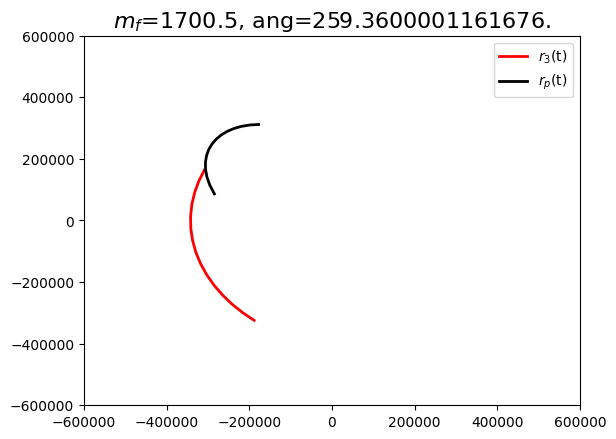

In [29]:
from matplotlib.animation import FuncAnimation

data_x = draw_data[:,4]-draw_data[:,2]
data_y = draw_data[:,5]-draw_data[:,3]

data_x2 = draw_data[:,6]-draw_data[:,2]
data_y2 = draw_data[:,7]-draw_data[:,3]


# Создаем фигуру и оси
fig, ax = plt.subplots()
line1, = ax.plot([], [], lw=2, label='$r_3$(t)', color = 'r')
line2, = ax.plot([], [], lw=2, label='$r_р$(t)', color= 'k')

# Установка границ графика и добавление легенды
ax.set_xlim(-600_000, 600_000)
ax.set_ylim(-600_000, 600_000)
ax.legend()
ax.set_title(f'$m_f$={optim_fuel}, ang={optim_ang / (2*np.pi) * 360}.', fontsize=16)

# Функция инициализации
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2


# Функция обновления для анимации
def update(frame):
    start = frame - 15
    # Обновляем данные линий
    line1.set_data(data_x[start:frame], data_y[start:frame])
    line2.set_data(data_x2[start:frame], data_y2[start:frame])
    return line1, line2

# Создание анимации
ani = FuncAnimation(fig, update, frames=len(data_x), init_func=init, blit=True, interval=50)
ani.save('ani.gif', writer='pillow', fps = 30)

# Показ графика
plt.show()

## Расчёт траекторий, при которых происходит столкновение

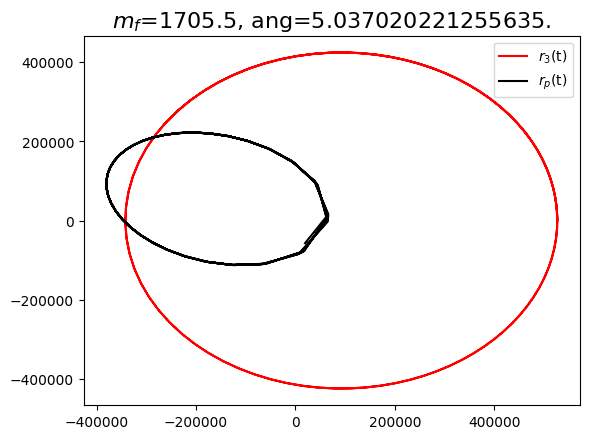

c:\Users\ernes\Desktop\code\env\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


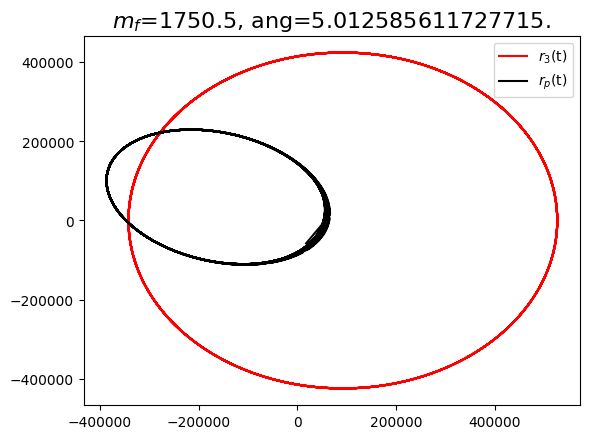

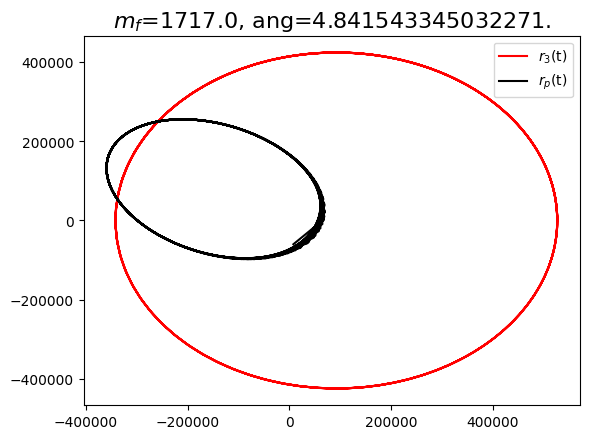

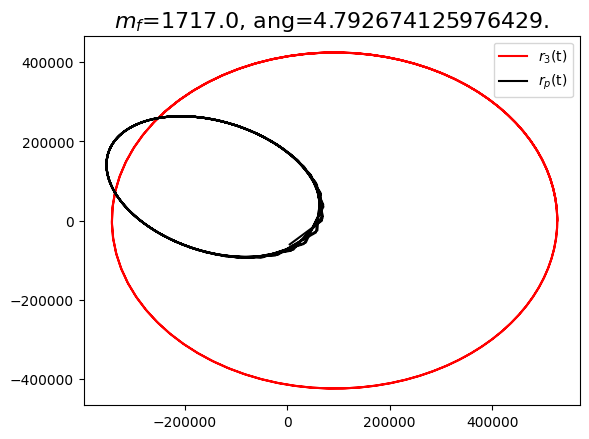

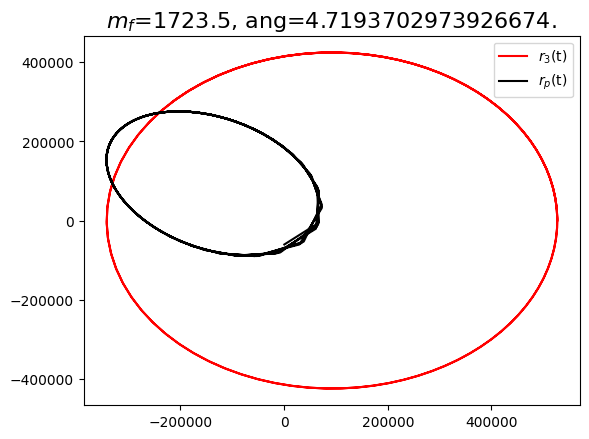

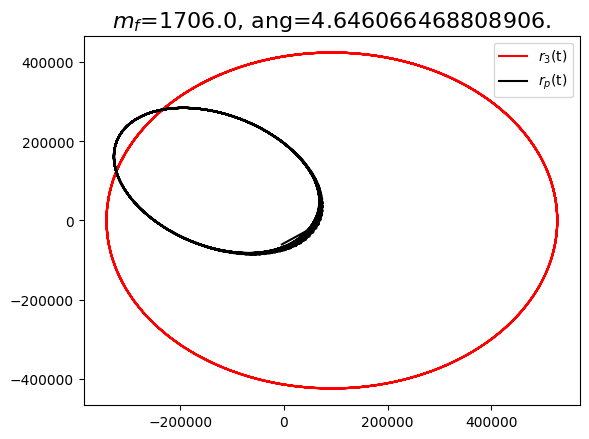

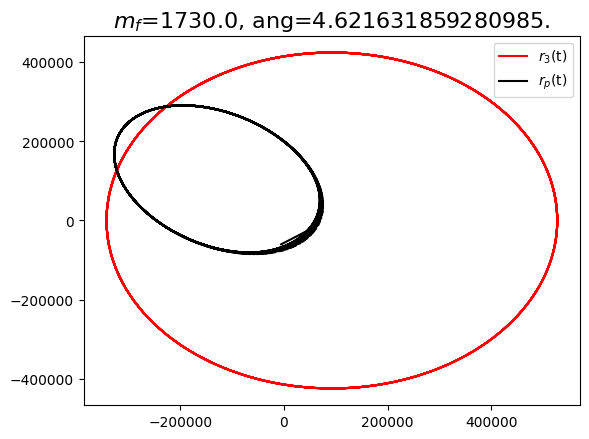

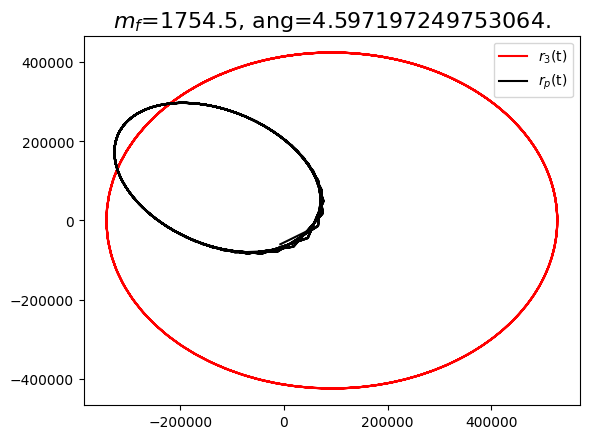

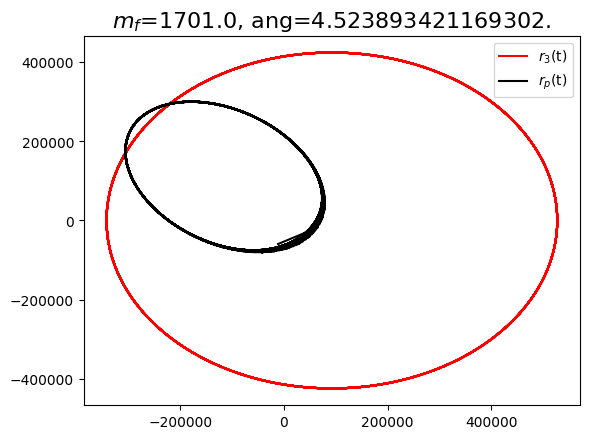

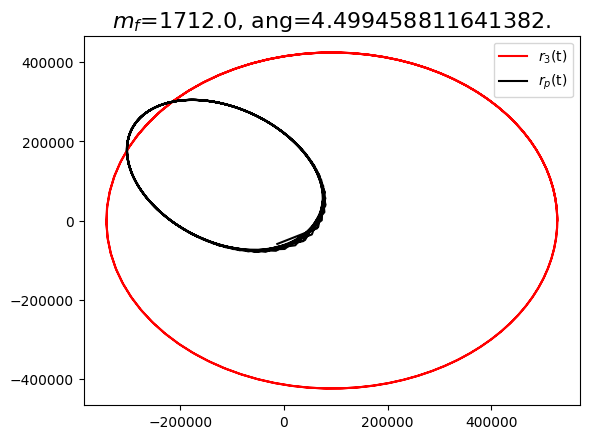

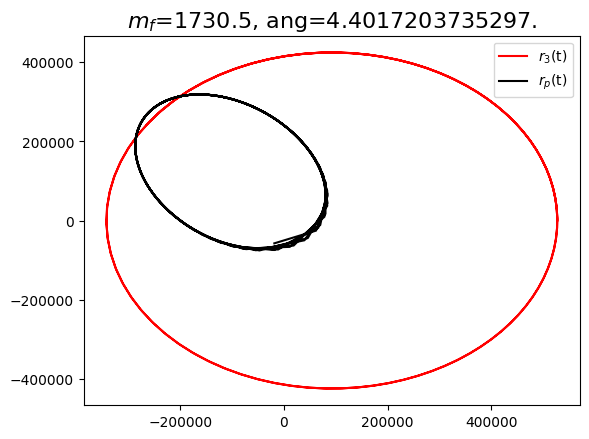

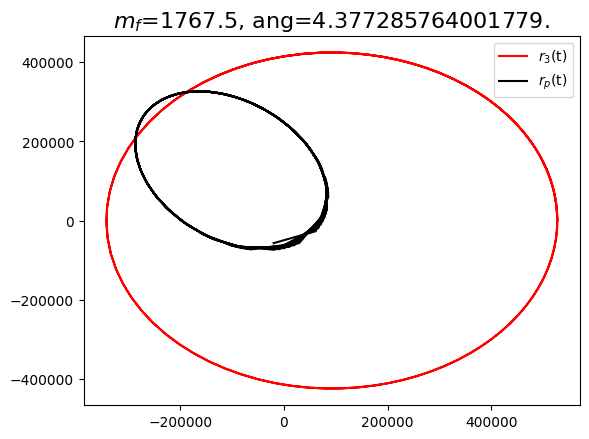

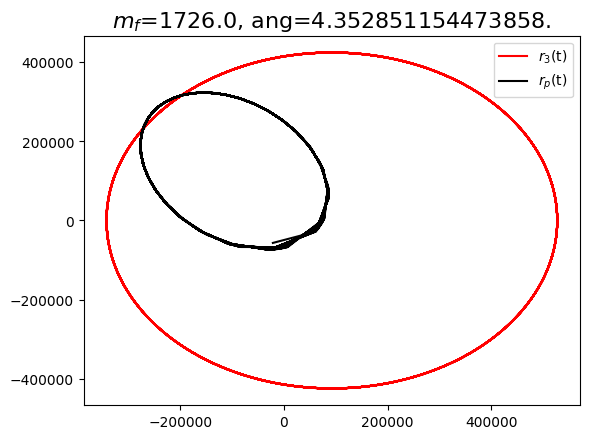

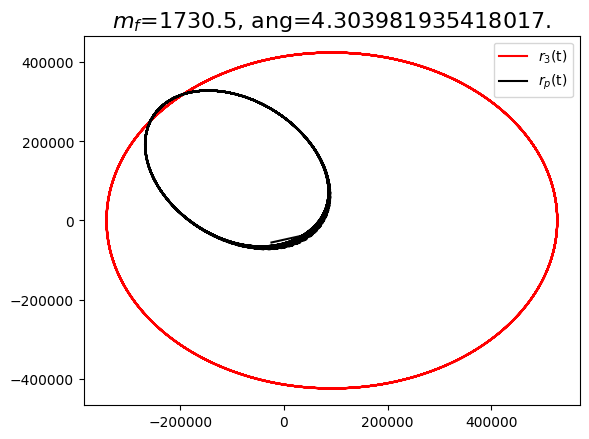

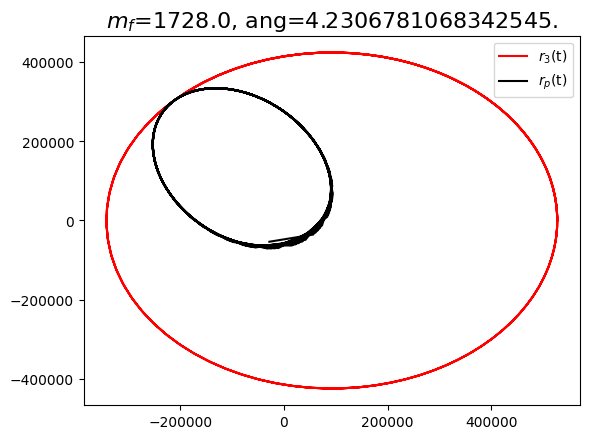

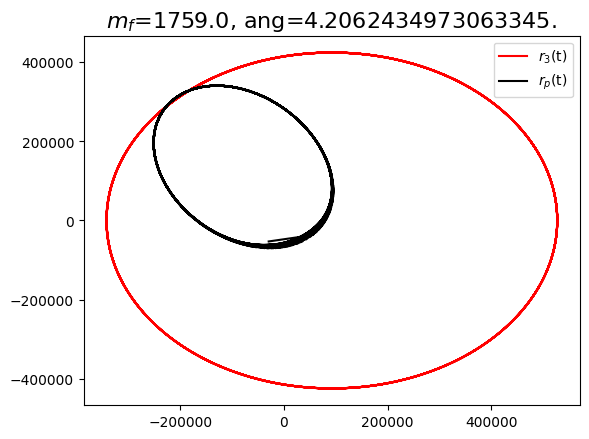

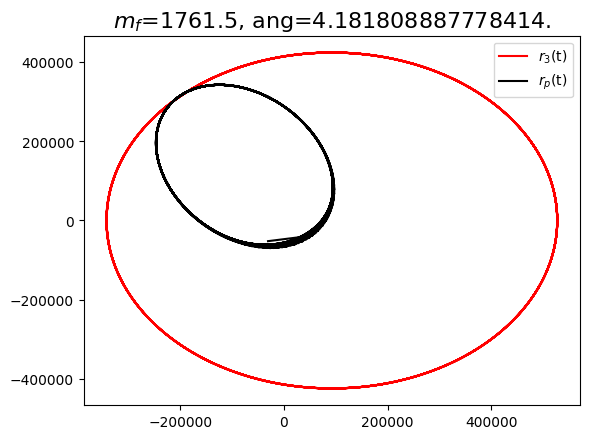

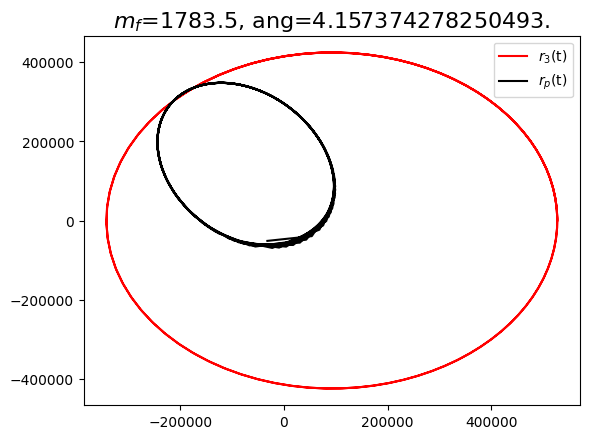

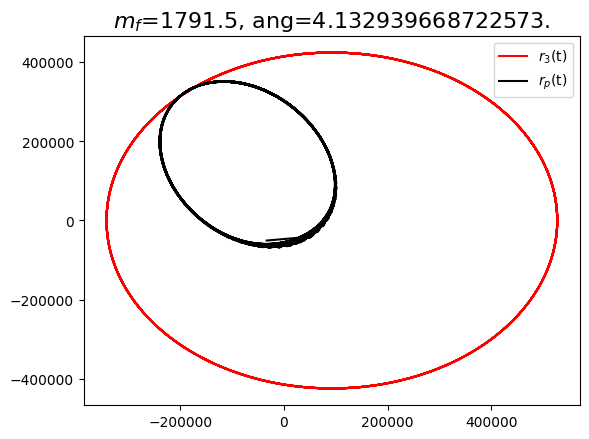

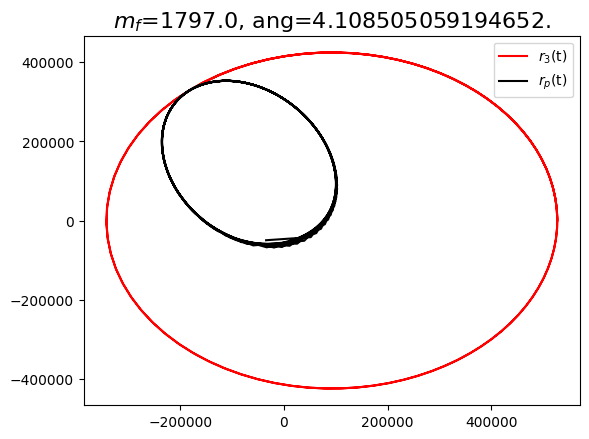

In [235]:
for f_val, cur_ang in list(zip(m_fuel_arr_coll,ang_arr_coll))[::]:
    m_cons = alpha * (f_val + m_pg) / (1 - alpha)

    def m_fuel(t):
        return 0 if t > t_fuel else f_val * (t_fuel - t)/t_fuel

    def m_r(t):
        return m_fuel(t) + m_cons + m_pg

    def f_react(t, v):
        return np.zeros(2) if t > t_fuel else v * u * f_val / (t_fuel*np.linalg.norm(v)*m_r(t))

    def system_full(y, t):
        dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7 = y[8:]
        f_12 = f_gr(y[0:2], y[2:4])
        f_13 = f_gr(y[0:2], y[4:6])
        f_1r = f_gr(y[0:2], y[6:8])
        f_23 = f_gr(y[2:4], y[4:6])
        f_2r = f_gr(y[2:4], y[6:8])
        f_3r = f_gr(y[4:6], y[6:8])
        dydt8, dydt9 = m2*f_12 + m3*f_13 + m_r(t)*f_1r
        dydt10, dydt11 = -m1*f_12 + m3*f_23 + m_r(t)*f_2r
        dydt12, dydt13 = -m1*f_13 - m2*f_23 + m_r(t)*f_3r
        dydt14, dydt15 =  -m1*f_1r - m2*f_2r -m3*f_3r + f_react(t, y[14:16])
        return np.array([dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7, dydt8, dydt9, dydt10, dydt11, dydt12, dydt13, dydt14, dydt15])
    
    r_r_init = np.array([x2, y2 ]) + np.array([r2+h, 0]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
    v_r_init = np.array([0, v2]) + np.array([0, cosmic_speed]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
    init_cond = np.array([0,0, r12, 0, r12+r23, 0, r_r_init[0], r_r_init[1], 0, 0, 0, v2, 0, v2+v3, v_r_init[0], v_r_init[1]])

    assert len(init_cond) == 16

    y_cur = init_cond.copy()
    t_cur = 0.

    coll_idx = -1
    coll = False

    t_eval = np.linspace(0, t_end, n+1)
    sol = odeint(system_full, init_cond, t_eval)

    for j in range(n):
        if np.linalg.norm(sol[j,4:6] - sol[j,6:8]) <= r3:
            coll_idx = j
            coll = True
            break
    all_data = sol[:coll_idx]
    draw_data = all_data
    plt.plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='$r_3$(t)')
    plt.plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='$r_р$(t)')
    plt.legend()
    plt.title(f'$m_f$={f_val}, ang={cur_ang}.', fontsize=16)
    plt.show()

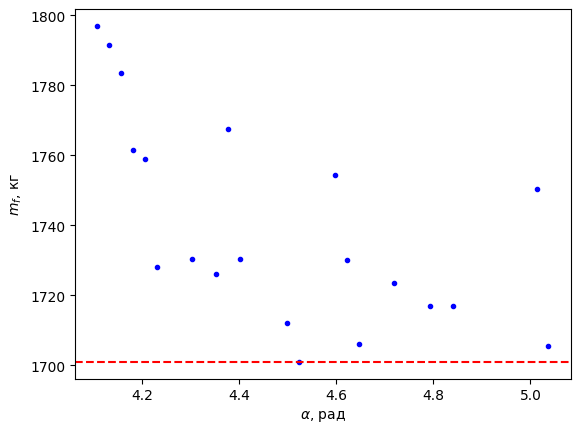

In [353]:
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b.')
plt.axhline(y=optim_fuel, color='r', linestyle='--')
plt.xlabel('$\\alpha$, рад')
plt.ylabel('$m_{f}$, кг')
plt.show()

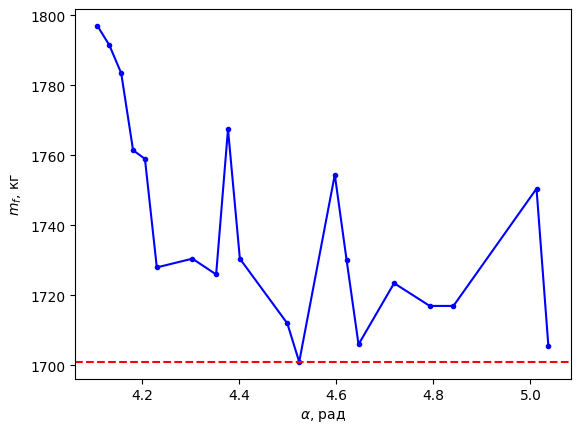

In [354]:
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b-')
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b.')
plt.axhline(y=1701, color='r', linestyle='--')
plt.xlabel('$\\alpha$, рад')
plt.ylabel('$m_{f}$, кг')
plt.show()